In [33]:
# Plots for assembly accuracy with lossy compression

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd

In [35]:
compressed_size_dir = '../../data/Staphylococcus_aureus_CAS38_02/compressed_size_summary/'
NUM_EXP = 10 # we tried maxerror parameter from 1 to 10

In [36]:
# load compressed sizes and signal lengths into numpy arrays
# array size = number of reads

with open(compressed_size_dir+'/VBZ_lossless.tsv') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    rows = [row for row in reader]
    
signal_lengths = np.array([int(row[1]) for row in rows[1:]],dtype=int)
lossless_sizes = np.array([int(row[2]) for row in rows[1:]],dtype=int)

LFZip_sizes = np.zeros((NUM_EXP,len(lossless_sizes)),dtype=int)
SZ_sizes = np.zeros((NUM_EXP,len(lossless_sizes)),dtype=int)

for i in range(NUM_EXP):
    with open(compressed_size_dir+'/LFZip_maxerror_'+str(i+1)+'.tsv') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        rows = [row for row in reader]
    LFZip_sizes[i,:] = np.array([int(row[2]) for row in rows[1:]],dtype=int)
    
for i in range(NUM_EXP):
    with open(compressed_size_dir+'/SZ_maxerror_'+str(i+1)+'.tsv') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        rows = [row for row in reader]
    SZ_sizes[i,:] = np.array([int(row[2]) for row in rows[1:]],dtype=int)
    

In [37]:
# compute some totals 
signal_lengths_sum = np.sum(signal_lengths)
lossless_sizes_sum = np.sum(lossless_sizes)
LFZip_sizes_sum = np.sum(LFZip_sizes,axis=1)
SZ_sizes_sum = np.sum(SZ_sizes,axis=1)

In [38]:
# Average compression ratio (bytes/signal value) for lossless compression
print('Lossless compression ratio:','{:.3f}'.format((lossless_sizes_sum/signal_lengths_sum)))

Lossless compression ratio: 0.832


In [39]:
# Now load the assembly data
data_dir = '../../data/Staphylococcus_aureus_CAS38_02/'

basecallers = ['guppy_hac','guppy_fast','bonito']
assemblers = ['flye','rebaler','medaka']
assembly_identity = {basecaller: [{'lossless':{},'LFZip':{},'SZ':{}} for _ in range(4)] for basecaller in basecallers}
num_contigs = {basecaller: [{'lossless':{},'LFZip':{},'SZ':{}} for _ in range(4)] for basecaller in basecallers}
total_length = {basecaller: [{'lossless':{},'LFZip':{},'SZ':{}} for _ in range(4)] for basecaller in basecallers}
hp_accuracy_5mer = {basecaller: [{'lossless':{},'LFZip':{},'SZ':{}} for _ in range(4)] for basecaller in basecallers}
hp_accuracy_6mer = {basecaller: [{'lossless':{},'LFZip':{},'SZ':{}} for _ in range(4)] for basecaller in basecallers}
hp_accuracy_7mer = {basecaller: [{'lossless':{},'LFZip':{},'SZ':{}} for _ in range(4)] for basecaller in basecallers}
hp_accuracy_8mer = {basecaller: [{'lossless':{},'LFZip':{},'SZ':{}} for _ in range(4)] for basecaller in basecallers}
# 4 subsampling experiments

for basecaller in basecallers:
    for j,subsampling_suffix in enumerate([".summary","_subsampled_2.summary","_subsampled_4.summary","_subsampled_8.summary"]):
        assembly_summary_file = data_dir+"/"+basecaller+"/assembly"+subsampling_suffix+".tsv"
        # read file
        with open(assembly_summary_file) as tsvfile:
            reader = csv.reader(tsvfile, delimiter='\t')
            rows = [row for row in reader]

        data_dict = {}
        for row in rows[1:]:
            data_dict[row[0]] = row[1:]
        for assembler in assemblers:
            assembly_identity[basecaller][j]['lossless'][assembler] = float(data_dict['lossless_'+assembler][2].rstrip('%'))
            num_contigs[basecaller][j]['lossless'][assembler] = int(data_dict['lossless_'+assembler][0])
            total_length[basecaller][j]['lossless'][assembler] = int(data_dict['lossless_'+assembler][1])
            hp_accuracy_5mer[basecaller][j]['lossless'][assembler] = float(data_dict['lossless_'+assembler][4])
            hp_accuracy_6mer[basecaller][j]['lossless'][assembler] = float(data_dict['lossless_'+assembler][5])
            hp_accuracy_7mer[basecaller][j]['lossless'][assembler] = float(data_dict['lossless_'+assembler][6])
            hp_accuracy_8mer[basecaller][j]['lossless'][assembler] = float(data_dict['lossless_'+assembler][7])

        for compressor in ['LFZip','SZ']:
            for assembler in assemblers:
                assembly_identity[basecaller][j][compressor][assembler] =\
                    np.array([float(data_dict[compressor+'_maxerror_'+str(i+1)+'_'+assembler][2].rstrip('%')) \
                                for i in range(NUM_EXP)])
                num_contigs[basecaller][j][compressor][assembler] =\
                    np.array([int(data_dict[compressor+'_maxerror_'+str(i+1)+'_'+assembler][0].rstrip('%')) \
                                for i in range(NUM_EXP)])
                total_length[basecaller][j][compressor][assembler] =\
                    np.array([int(data_dict[compressor+'_maxerror_'+str(i+1)+'_'+assembler][1].rstrip('%')) \
                                for i in range(NUM_EXP)])
                hp_accuracy_5mer[basecaller][j][compressor][assembler] =\
                    np.array([float(data_dict[compressor+'_maxerror_'+str(i+1)+'_'+assembler][4].rstrip('%')) \
                                for i in range(NUM_EXP)])
                hp_accuracy_6mer[basecaller][j][compressor][assembler] =\
                    np.array([float(data_dict[compressor+'_maxerror_'+str(i+1)+'_'+assembler][5].rstrip('%')) \
                                for i in range(NUM_EXP)])
                hp_accuracy_7mer[basecaller][j][compressor][assembler] =\
                    np.array([float(data_dict[compressor+'_maxerror_'+str(i+1)+'_'+assembler][6].rstrip('%')) \
                                for i in range(NUM_EXP)])
                hp_accuracy_8mer[basecaller][j][compressor][assembler] =\
                    np.array([float(data_dict[compressor+'_maxerror_'+str(i+1)+'_'+assembler][7].rstrip('%')) \
                                for i in range(NUM_EXP)])

                

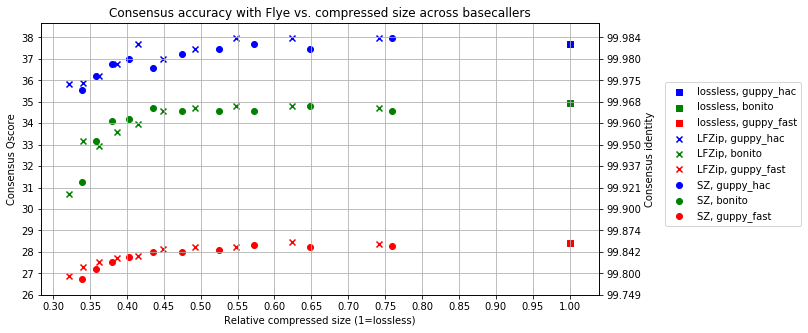

In [40]:
# flye assembly across basecallers

basecallers = ['guppy_hac','bonito','guppy_fast']
color = {'guppy_hac': 'b', 'guppy_fast': 'r','bonito':'g'}
marker = {'LFZip': 'x', 'SZ': 'o'}
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

assembler = 'flye'
sidx = 0 # no subsampling

# scatter plots
for basecaller in basecallers:
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[basecaller])
    legend.append('lossless, '+basecaller)
for compressor in ['LFZip','SZ']:
    for basecaller in basecallers:
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[basecaller], marker=marker[compressor])
        legend.append(compressor+', '+basecaller)
ax_phred.legend(legend,bbox_to_anchor=(1.11,0.8), loc="upper left")
yticks = list(range(26,39))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_phred.set_title('Consensus accuracy with Flye vs. compressed size across basecallers')
ax_percent.set_ylabel('Consensus identity')
ax_phred.grid()
plt.savefig('pdf_figures/basecallers_flye_assembly.pdf',bbox_inches='tight')
plt.savefig('png_figures/basecallers_flye_assembly.png',bbox_inches='tight')

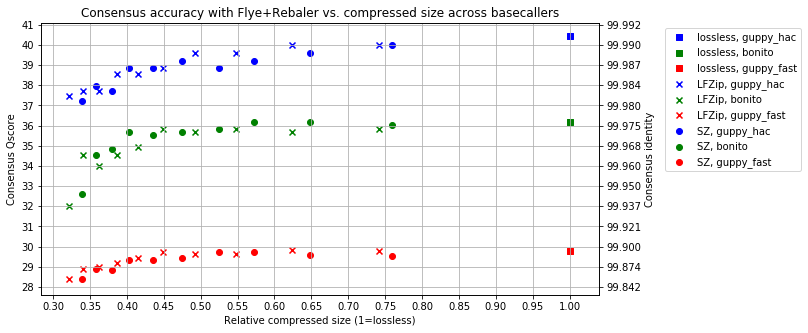

In [41]:
# rebaler assembly across basecallers

basecallers = ['guppy_hac','bonito','guppy_fast']
color = {'guppy_hac': 'b', 'guppy_fast': 'r','bonito':'g'}
marker = {'LFZip': 'x', 'SZ': 'o'}
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

assembler = 'rebaler'
sidx = 0 # no subsampling

# scatter plots
for basecaller in basecallers:
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[basecaller])
    legend.append('lossless, '+basecaller)
for compressor in ['LFZip','SZ']:
    for basecaller in basecallers:
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[basecaller], marker=marker[compressor])
        legend.append(compressor+', '+basecaller)
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = list(range(28,42))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_phred.set_title('Consensus accuracy with Flye+Rebaler vs. compressed size across basecallers')
ax_percent.set_ylabel('Consensus identity')
ax_phred.grid()
plt.savefig('pdf_figures/basecallers_rebaler_assembly.pdf',bbox_inches='tight')
plt.savefig('png_figures/basecallers_rebaler_assembly.png',bbox_inches='tight')

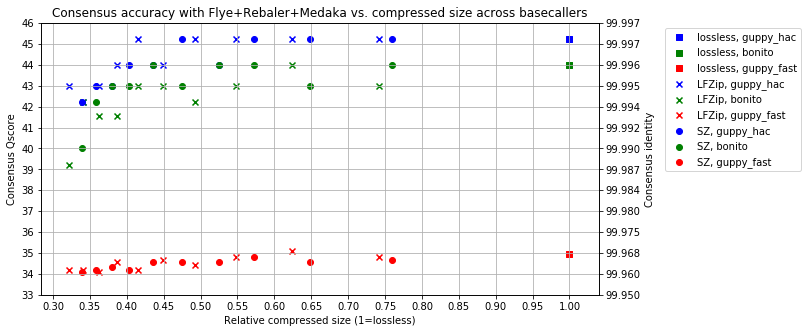

In [42]:
# medaka assembly across basecallers

basecallers = ['guppy_hac','bonito','guppy_fast']
color = {'guppy_hac': 'b', 'guppy_fast': 'r','bonito':'g'}
marker = {'LFZip': 'x', 'SZ': 'o'}
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

assembler = 'medaka'
sidx = 0 # no subsampling

# scatter plots
for basecaller in basecallers:
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[basecaller])
    legend.append('lossless, '+basecaller)
for compressor in ['LFZip','SZ']:
    for basecaller in basecallers:
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[basecaller], marker=marker[compressor])
        legend.append(compressor+', '+basecaller)
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = list(range(33,47))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_phred.set_title('Consensus accuracy with Flye+Rebaler+Medaka vs. compressed size across basecallers')
ax_percent.set_ylabel('Consensus identity')
ax_phred.grid()
plt.savefig('pdf_figures/basecallers_medaka_assembly.pdf',bbox_inches='tight')
plt.savefig('png_figures/basecallers_medaka_assembly.png',bbox_inches='tight')

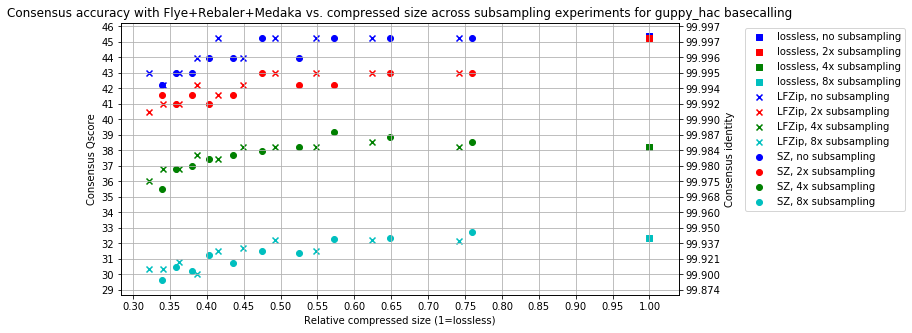

In [47]:
# medaka assembly across subsampling (guppy_hac)
marker = {'LFZip': 'x', 'SZ': 'o'}
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

assembler = 'medaka'
basecaller = 'guppy_hac'
subsampling_legend = ['no subsampling','2x subsampling','4x subsampling', '8x subsampling']
color = ['b','r','g','c']

# scatter plots (slightly shift first to avoid overlap)
sidx=0
ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]+0.0001),marker='s',color=color[sidx])
legend.append('lossless, '+subsampling_legend[sidx])

for sidx in range(1,4):
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[sidx])
    legend.append('lossless, '+subsampling_legend[sidx])
for compressor in ['LFZip','SZ']:
    for sidx in range(4):
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[sidx], marker=marker[compressor])
        legend.append(compressor+', '+subsampling_legend[sidx])
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = list(range(29,47))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_phred.set_title('Consensus accuracy with Flye+Rebaler+Medaka vs. compressed size across subsampling experiments for guppy_hac basecalling')
ax_percent.set_ylabel('Consensus identity')
ax_phred.grid()
plt.savefig('pdf_figures/subsampling_medaka_guppy_hac_assembly.pdf',bbox_inches='tight')
plt.savefig('png_figures/subsampling_medaka_guppy_hac_assembly.png',bbox_inches='tight')

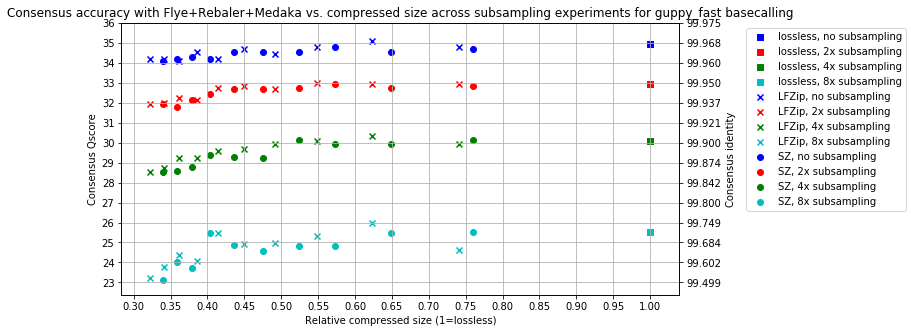

In [48]:
# medaka assembly across subsampling (guppy_fast)
marker = {'LFZip': 'x', 'SZ': 'o'}
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

assembler = 'medaka'
basecaller = 'guppy_fast'
subsampling_legend = ['no subsampling','2x subsampling','4x subsampling', '8x subsampling']
color = ['b','r','g','c']

# scatter plots
for sidx in range(4):
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[sidx])
    legend.append('lossless, '+subsampling_legend[sidx])
for compressor in ['LFZip','SZ']:
    for sidx in range(4):
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[sidx], marker=marker[compressor])
        legend.append(compressor+', '+subsampling_legend[sidx])
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = list(range(23,37))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_phred.set_title('Consensus accuracy with Flye+Rebaler+Medaka vs. compressed size across subsampling experiments for guppy_fast basecalling')
ax_percent.set_ylabel('Consensus identity')
ax_phred.grid()
plt.savefig('pdf_figures/subsampling_medaka_guppy_fast_assembly.pdf',bbox_inches='tight')
plt.savefig('png_figures/subsampling_medaka_guppy_fast_assembly.png',bbox_inches='tight')

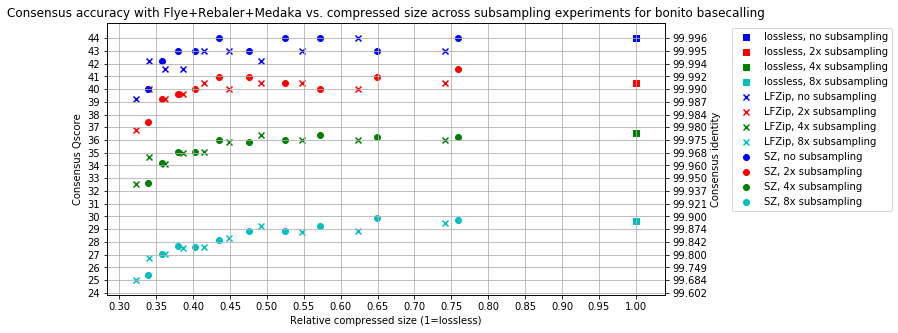

In [49]:
# medaka assembly across subsampling (bonito)
marker = {'LFZip': 'x', 'SZ': 'o'}
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

assembler = 'medaka'
basecaller = 'bonito'
subsampling_legend = ['no subsampling','2x subsampling','4x subsampling', '8x subsampling']
color = ['b','r','g','c']

# scatter plots
for sidx in range(4):
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[sidx])
    legend.append('lossless, '+subsampling_legend[sidx])
for compressor in ['LFZip','SZ']:
    for sidx in range(4):
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[sidx], marker=marker[compressor])
        legend.append(compressor+', '+subsampling_legend[sidx])
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = list(range(24,45))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_phred.set_title('Consensus accuracy with Flye+Rebaler+Medaka vs. compressed size across subsampling experiments for bonito basecalling')
ax_percent.set_ylabel('Consensus identity')
ax_phred.grid()
plt.savefig('pdf_figures/subsampling_medaka_bonito_assembly.pdf',bbox_inches='tight')
plt.savefig('png_figures/subsampling_medaka_bonito_assembly.png',bbox_inches='tight')

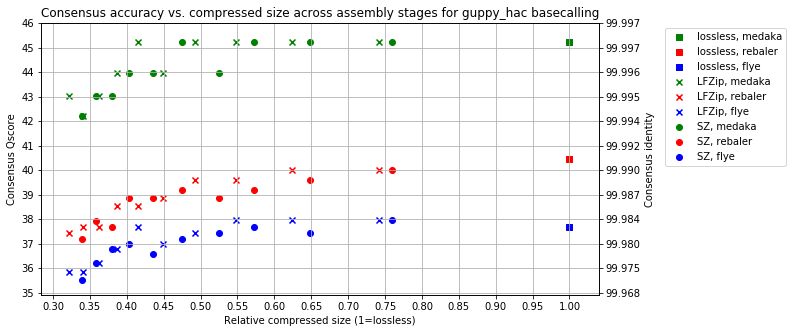

In [50]:
assemblers = ['medaka','rebaler','flye',]
color = {'flye': 'b', 'rebaler': 'r', 'medaka': 'g'}
marker = {'LFZip': 'x', 'SZ': 'o'}
basecaller = 'guppy_hac'
sidx = 0 # no subsampling
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

# scatter plots
for assembler in assemblers:
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[assembler])
    legend.append('lossless, '+assembler)
for compressor in ['LFZip','SZ']:
    for assembler in assemblers:
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[assembler], marker=marker[compressor])
        legend.append(compressor+', '+assembler)
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = list(range(35,47))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_percent.set_ylabel('Consensus identity')
ax_phred.set_title('Consensus accuracy vs. compressed size across assembly stages for guppy_hac basecalling')
ax_phred.grid()
plt.savefig('pdf_figures/assemblers_guppy_hac_assembly.pdf',bbox_inches='tight')
plt.savefig('png_figures/assemblers_guppy_hac_assembly.png',bbox_inches='tight')

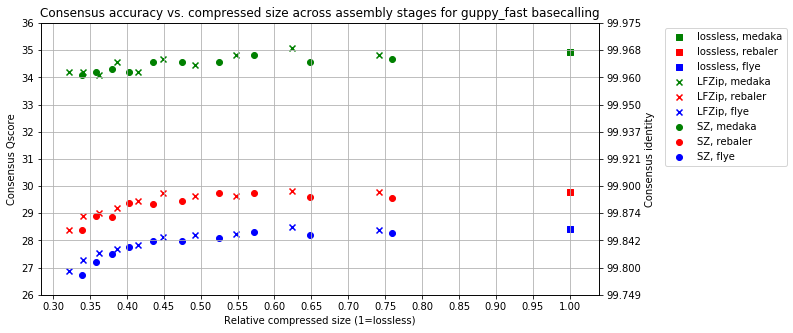

In [52]:
assemblers = ['medaka','rebaler','flye',]
color = {'flye': 'b', 'rebaler': 'r', 'medaka': 'g'}
marker = {'LFZip': 'x', 'SZ': 'o'}
basecaller = 'guppy_fast'
sidx = 0 # no subsampling
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

# scatter plots
for assembler in assemblers:
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[assembler])
    legend.append('lossless, '+assembler)
for compressor in ['LFZip','SZ']:
    for assembler in assemblers:
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[assembler], marker=marker[compressor])
        legend.append(compressor+', '+assembler)
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = list(range(26,37))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_percent.set_ylabel('Consensus identity')
ax_phred.set_title('Consensus accuracy vs. compressed size across assembly stages for guppy_fast basecalling')
ax_phred.grid()
plt.savefig('pdf_figures/assemblers_guppy_fast_assembly.pdf',bbox_inches='tight')
plt.savefig('png_figures/assemblers_guppy_fast_assembly.png',bbox_inches='tight')

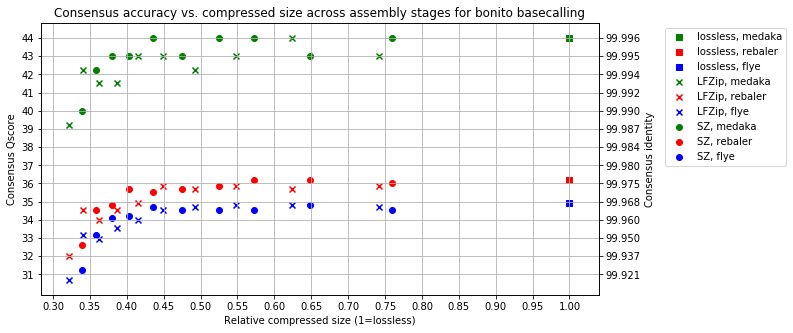

In [53]:
assemblers = ['medaka','rebaler','flye',]
color = {'flye': 'b', 'rebaler': 'r', 'medaka': 'g'}
marker = {'LFZip': 'x', 'SZ': 'o'}
basecaller = 'bonito'
sidx = 0 # no subsampling
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

# scatter plots
for assembler in assemblers:
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[assembler])
    legend.append('lossless, '+assembler)
for compressor in ['LFZip','SZ']:
    for assembler in assemblers:
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[assembler], marker=marker[compressor])
        legend.append(compressor+', '+assembler)
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = list(range(31,45))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_percent.set_ylabel('Consensus identity')
ax_phred.set_title('Consensus accuracy vs. compressed size across assembly stages for bonito basecalling')
ax_phred.grid()
plt.savefig('pdf_figures/assemblers_bonito_assembly.pdf',bbox_inches='tight')
plt.savefig('png_figures/assemblers_bonito_assembly.png',bbox_inches='tight')

In [54]:
# Now plot the additional info including number of contigs, assembly length and homopolymer accuracy
# Do this for guppy_hac, medaka assembly and all subsamplings

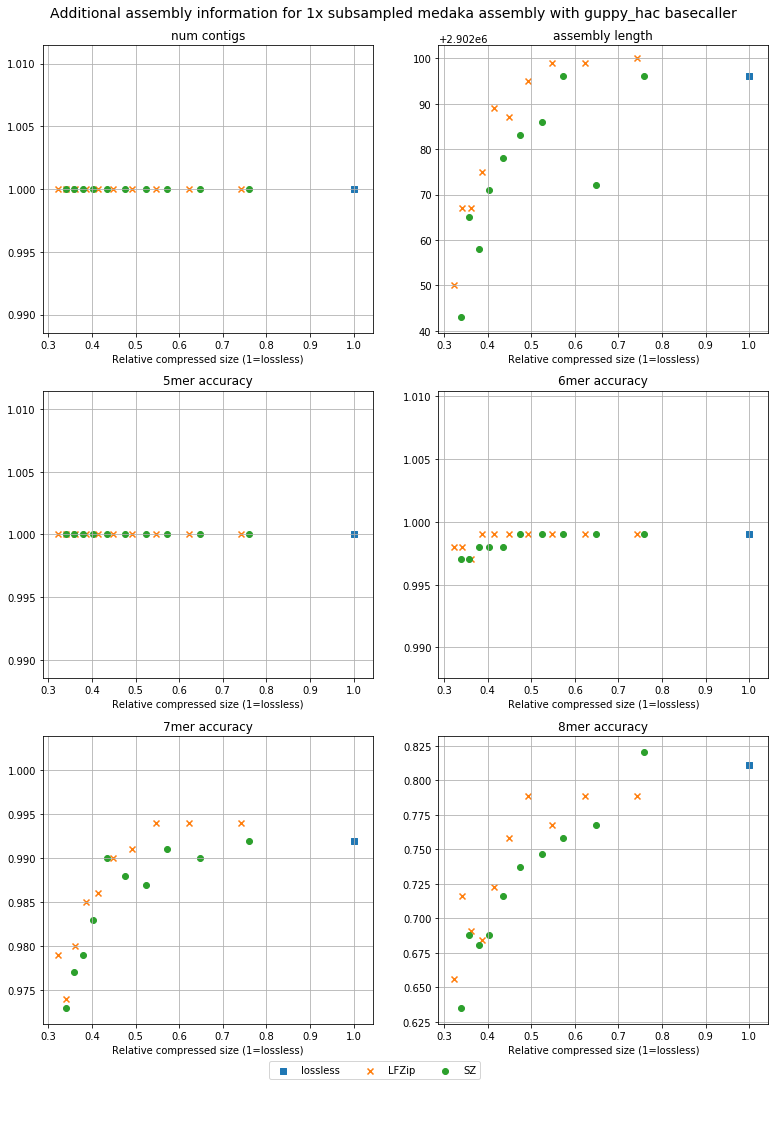

In [72]:
marker = {'LFZip': 'x', 'SZ': 'o'}
basecaller = 'guppy_hac'
assembler = 'medaka'

sidx = 0 # no subsampling

legend = ['lossless','LFZip','SZ']

fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(13,18))

for ax_ in ax.flatten():
    ax_.set_xticks(np.arange(0.3,1.05,0.1))
    ax_.set_xlabel('Relative compressed size (1=lossless)')

ax[0,0].scatter(1.0,num_contigs[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[0,0].scatter(compressed_sizes[compressor],\
                    num_contigs[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[0,0].grid()
ax[0,0].set_title('num contigs') 
    
ax[0,1].scatter(1.0,total_length[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[0,1].scatter(compressed_sizes[compressor],\
                    total_length[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[0,1].grid()
ax[0,1].set_title('assembly length') 


ax[1,0].scatter(1.0,hp_accuracy_5mer[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[1,0].scatter(compressed_sizes[compressor],\
                    hp_accuracy_5mer[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[1,0].grid()
ax[1,0].set_title('5mer accuracy') 


ax[1,1].scatter(1.0,hp_accuracy_6mer[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[1,1].scatter(compressed_sizes[compressor],\
                    hp_accuracy_6mer[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[1,1].grid()
ax[1,1].set_title('6mer accuracy') 


ax[2,0].scatter(1.0,hp_accuracy_7mer[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[2,0].scatter(compressed_sizes[compressor],\
                    hp_accuracy_7mer[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[2,0].grid()
ax[2,0].set_title('7mer accuracy') 


ax[2,1].scatter(1.0,hp_accuracy_8mer[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[2,1].scatter(compressed_sizes[compressor],\
                    hp_accuracy_8mer[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[2,1].grid()
ax[2,1].set_title('8mer accuracy') 

    
fig.legend(legend, bbox_to_anchor=(0.4,0.04), ncol=3, loc="lower center")
fig.suptitle('Additional assembly information for 1x subsampled medaka assembly with guppy_hac basecaller',y=0.91,fontsize=14)
plt.savefig('pdf_figures/additional_subsampled_1x_medaka_guppy_hac_assembly.pdf',bbox_inches='tight')
plt.savefig('png_figures/additional_subsampled_1x_medaka_guppy_hac_assembly.png',bbox_inches='tight')

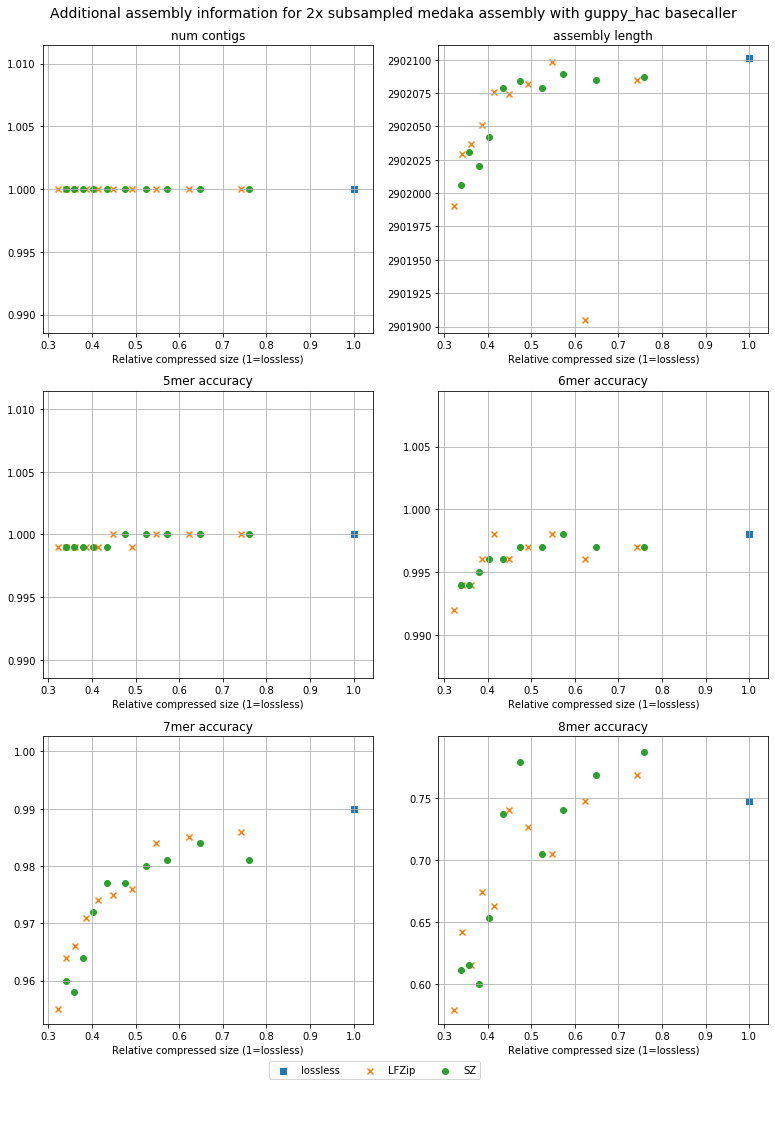

In [73]:
marker = {'LFZip': 'x', 'SZ': 'o'}
basecaller = 'guppy_hac'
assembler = 'medaka'

sidx = 1 # 2x subsampling

legend = ['lossless','LFZip','SZ']

fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(13,18))

for ax_ in ax.flatten():
    ax_.set_xticks(np.arange(0.3,1.05,0.1))
    ax_.set_xlabel('Relative compressed size (1=lossless)')


ax[0,0].scatter(1.0,num_contigs[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[0,0].scatter(compressed_sizes[compressor],\
                    num_contigs[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[0,0].grid()
ax[0,0].set_title('num contigs') 
    
ax[0,1].scatter(1.0,total_length[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[0,1].scatter(compressed_sizes[compressor],\
                    total_length[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[0,1].grid()
ax[0,1].set_title('assembly length') 


ax[1,0].scatter(1.0,hp_accuracy_5mer[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[1,0].scatter(compressed_sizes[compressor],\
                    hp_accuracy_5mer[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[1,0].grid()
ax[1,0].set_title('5mer accuracy') 


ax[1,1].scatter(1.0,hp_accuracy_6mer[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[1,1].scatter(compressed_sizes[compressor],\
                    hp_accuracy_6mer[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[1,1].grid()
ax[1,1].set_title('6mer accuracy') 


ax[2,0].scatter(1.0,hp_accuracy_7mer[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[2,0].scatter(compressed_sizes[compressor],\
                    hp_accuracy_7mer[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[2,0].grid()
ax[2,0].set_title('7mer accuracy') 


ax[2,1].scatter(1.0,hp_accuracy_8mer[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[2,1].scatter(compressed_sizes[compressor],\
                    hp_accuracy_8mer[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[2,1].grid()
ax[2,1].set_title('8mer accuracy') 

    
fig.legend(legend, bbox_to_anchor=(0.4,0.04), ncol=3, loc="lower center")
fig.suptitle('Additional assembly information for 2x subsampled medaka assembly with guppy_hac basecaller',y=0.91,fontsize=14)

plt.savefig('pdf_figures/additional_subsampled_2x_medaka_guppy_hac_assembly.pdf',bbox_inches='tight')
plt.savefig('png_figures/additional_subsampled_2x_medaka_guppy_hac_assembly.png',bbox_inches='tight')

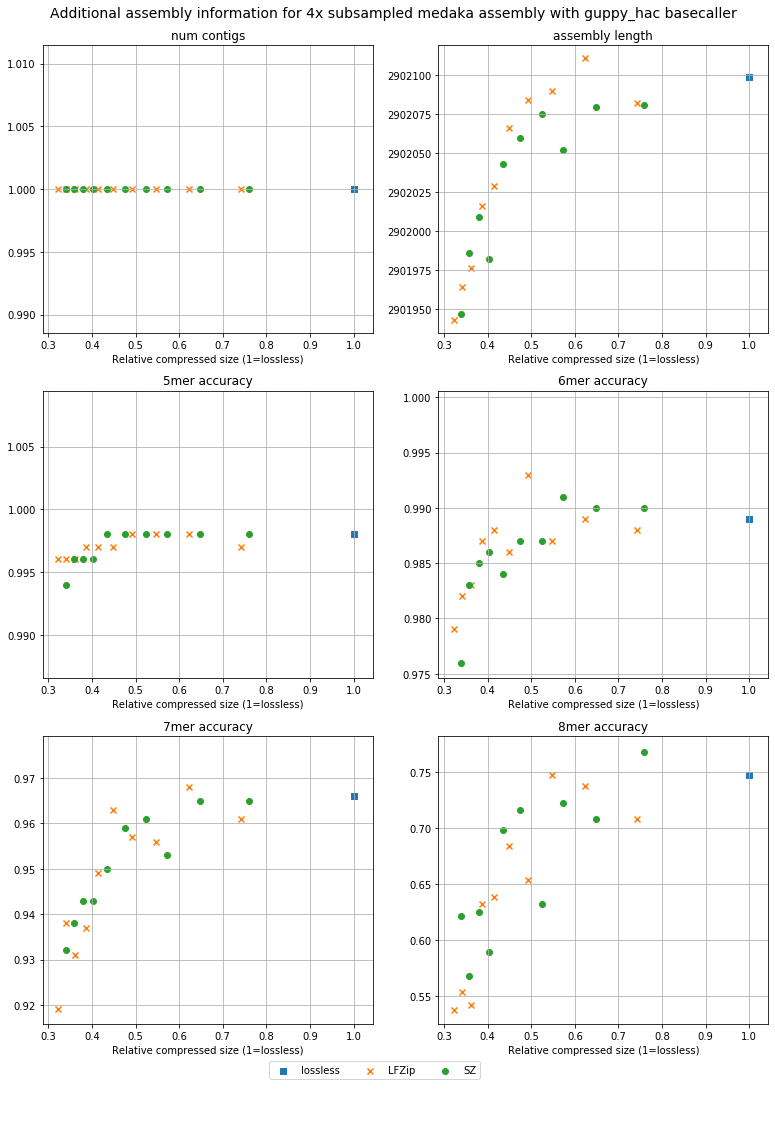

In [74]:
marker = {'LFZip': 'x', 'SZ': 'o'}
basecaller = 'guppy_hac'
assembler = 'medaka'

sidx = 2 # 4x subsampling

legend = ['lossless','LFZip','SZ']

fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(13,18))

for ax_ in ax.flatten():
    ax_.set_xticks(np.arange(0.3,1.05,0.1))
    ax_.set_xlabel('Relative compressed size (1=lossless)')

ax[0,0].scatter(1.0,num_contigs[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[0,0].scatter(compressed_sizes[compressor],\
                    num_contigs[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[0,0].grid()
ax[0,0].set_title('num contigs') 
    
ax[0,1].scatter(1.0,total_length[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[0,1].scatter(compressed_sizes[compressor],\
                    total_length[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[0,1].grid()
ax[0,1].set_title('assembly length') 


ax[1,0].scatter(1.0,hp_accuracy_5mer[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[1,0].scatter(compressed_sizes[compressor],\
                    hp_accuracy_5mer[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[1,0].grid()
ax[1,0].set_title('5mer accuracy') 


ax[1,1].scatter(1.0,hp_accuracy_6mer[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[1,1].scatter(compressed_sizes[compressor],\
                    hp_accuracy_6mer[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[1,1].grid()
ax[1,1].set_title('6mer accuracy') 


ax[2,0].scatter(1.0,hp_accuracy_7mer[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[2,0].scatter(compressed_sizes[compressor],\
                    hp_accuracy_7mer[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[2,0].grid()
ax[2,0].set_title('7mer accuracy') 


ax[2,1].scatter(1.0,hp_accuracy_8mer[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[2,1].scatter(compressed_sizes[compressor],\
                    hp_accuracy_8mer[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[2,1].grid()
ax[2,1].set_title('8mer accuracy') 

    
fig.legend(legend, bbox_to_anchor=(0.4,0.04), ncol=3, loc="lower center")
fig.suptitle('Additional assembly information for 4x subsampled medaka assembly with guppy_hac basecaller',y=0.91,fontsize=14)

plt.savefig('pdf_figures/additional_subsampled_4x_medaka_guppy_hac_assembly.pdf',bbox_inches='tight')
plt.savefig('png_figures/additional_subsampled_4x_medaka_guppy_hac_assembly.png',bbox_inches='tight')

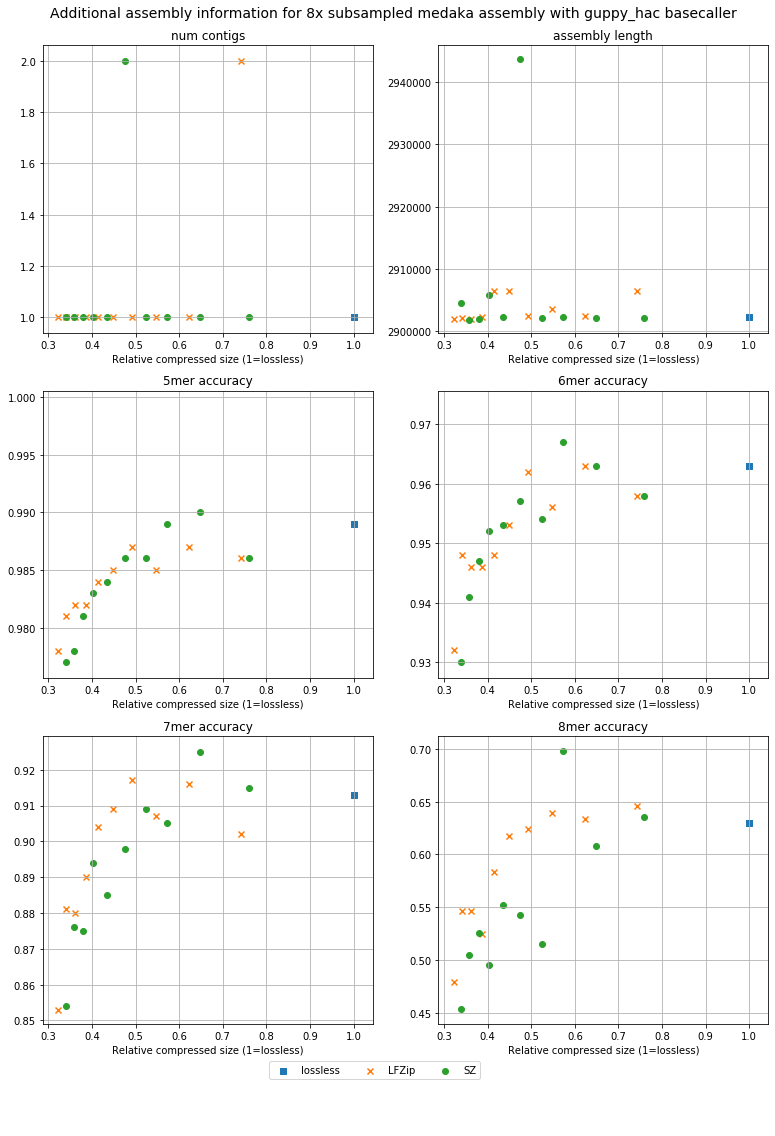

In [75]:
marker = {'LFZip': 'x', 'SZ': 'o'}
basecaller = 'guppy_hac'
assembler = 'medaka'

sidx = 3 # 8x subsampling

legend = ['lossless','LFZip','SZ']

fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(13,18))

for ax_ in ax.flatten():
    ax_.set_xticks(np.arange(0.3,1.05,0.1))
    ax_.set_xlabel('Relative compressed size (1=lossless)')

ax[0,0].scatter(1.0,num_contigs[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[0,0].scatter(compressed_sizes[compressor],\
                    num_contigs[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[0,0].grid()
ax[0,0].set_title('num contigs') 


ax[0,1].scatter(1.0,total_length[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[0,1].scatter(compressed_sizes[compressor],\
                    total_length[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[0,1].grid()
ax[0,1].set_title('assembly length') 


ax[1,0].scatter(1.0,hp_accuracy_5mer[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[1,0].scatter(compressed_sizes[compressor],\
                    hp_accuracy_5mer[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[1,0].grid()
ax[1,0].set_title('5mer accuracy') 


ax[1,1].scatter(1.0,hp_accuracy_6mer[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[1,1].scatter(compressed_sizes[compressor],\
                    hp_accuracy_6mer[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[1,1].grid()
ax[1,1].set_title('6mer accuracy') 


ax[2,0].scatter(1.0,hp_accuracy_7mer[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[2,0].scatter(compressed_sizes[compressor],\
                    hp_accuracy_7mer[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[2,0].grid()
ax[2,0].set_title('7mer accuracy') 


ax[2,1].scatter(1.0,hp_accuracy_8mer[basecaller][sidx]['lossless'][assembler],marker='s')
for compressor in ['LFZip','SZ']:
    ax[2,1].scatter(compressed_sizes[compressor],\
                    hp_accuracy_8mer[basecaller][sidx][compressor][assembler],\
                    marker=marker[compressor])
ax[2,1].grid()
ax[2,1].set_title('8mer accuracy') 

    
fig.legend(legend, bbox_to_anchor=(0.4,0.04), ncol=3, loc="lower center")
fig.suptitle('Additional assembly information for 8x subsampled medaka assembly with guppy_hac basecaller',y=0.91,fontsize=14)

plt.savefig('pdf_figures/additional_subsampled_8x_medaka_guppy_hac_assembly.pdf',bbox_inches='tight')
plt.savefig('png_figures/additional_subsampled_8x_medaka_guppy_hac_assembly.png',bbox_inches='tight')